# **ZOIDBERG2.0**

## Introduction

Le but de ce projet est de mettre en place un modèle de machine learning capable de détecter des cas de pneumonie à partir de radiographies, modèle qui doit être le plus performant possible. Pour cela nous allons mettre en place plusieurs algorithmes, optimiser les hyperparamètres, pré-traiter la donnée pour avoir un temps de calcul optimal, et visualiser les résultats à partir de métriques de performance. En bonus, on verra pour déployer le modèle pour l'utiliser en production.

### Sommaire du travail réalisé (et qui reste à faire)
- 1. Chargement des données et preprocessing
- 2. Réduction de dimensionnalité
- 3. Test de différents modèles
- 4. Comparaison des modèles
- 5. Visualisation des résultats
- 6. Sélection du meilleur modèle
- 7. Conclusion
- 8. Sauvegarde et déploiement du modèle
-----
- Preprocessing : Grayscale, Resize, Normalization
- Data augmentation : Random rotation, Random cropping, Random flipping (à faire)
- PCA
- KNN -> chercher à optimiser n_neighbors (+tester SVM, Random Forest, CNN, etc.)
- Validation croisée (avec un StratifiedKFold à 5 folds) -> mettre en place une comparaison avec train-test split
- Visualisation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

## 1. **Chargement des données et Preprocessing**
- On va créer des dataframes contenant les images et leurs labels, en ne prenant pas en compte les fichiers cachés
- Puis pour améliorer les performances/l'efficience on va passer les images en niveaux de gris, les redimensionner à la baisse et les normaliser. (pourquoi pas faire de la data augmentation si besoin de + de données ou d'avoir un dataset équilibré)

### 1.1 **Chargement des DataFrames**
- Visualisation d'exemples d'images pour comprendre les différences entre les classes.
- Analyse du déséquilibre des classes pour anticiper les biais potentiels.

In [59]:
base_dir = "./data/chest_Xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


def create_dataframe_from_pneumonia_directory(directory):
    file_paths = []
    labels = []
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.startswith(".") or "Zone.Identifier" in img_name:
                continue
            img_path = os.path.join(class_dir, img_name)
            file_paths.append(img_path)
            labels.append(0 if class_name == "NORMAL" else 1)  # 0: NORMAL, 1: PNEUMONIA
    return pd.DataFrame({"file_path": file_paths, "label": labels})


train_df = create_dataframe_from_pneumonia_directory(train_dir)
val_df = create_dataframe_from_pneumonia_directory(val_dir)
test_df = create_dataframe_from_pneumonia_directory(test_dir)

print("Train:", train_df["label"].value_counts())
print("Val:", val_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

Train: label
1    3875
0    1341
Name: count, dtype: int64
Val: label
0    8
1    8
Name: count, dtype: int64
Test: label
1    390
0    234
Name: count, dtype: int64


### 1.2 **Analyse exploratoire**
- Visualisation d'exemples d'images pour comprendre les différences entre les classes.
- Analyse du déséquilibre des classes pour anticiper les biais potentiels.

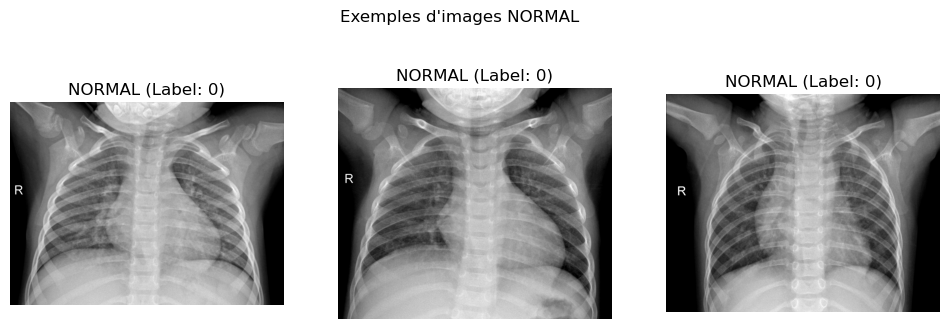

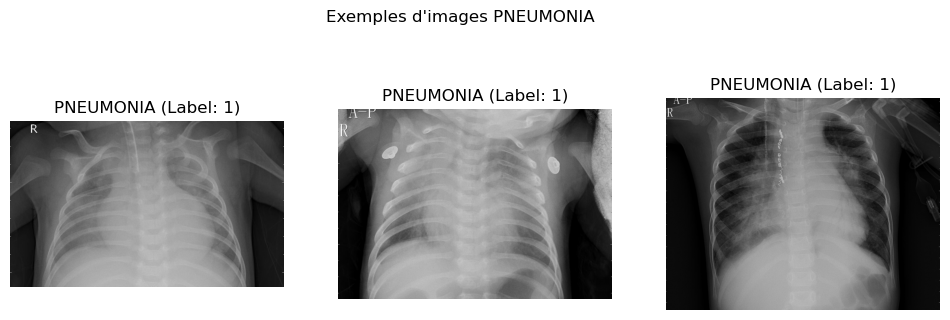

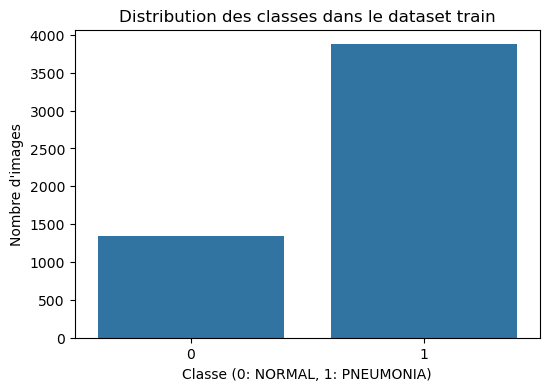

Ratio PNEUMONIA/NORMAL : 2.89


In [60]:
# Visualiser quelques images
def plot_sample_images(df, class_name, num_samples=3):
    class_df = df[df['label'] == (0 if class_name == "NORMAL" else 1)].sample(num_samples, random_state=42)
    plt.figure(figsize=(12, 4))
    for i, (_, row) in enumerate(class_df.iterrows()):
        img = cv2.imread(row['file_path'], cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_name} (Label: {row['label']})")
        plt.axis('off')
    plt.suptitle(f"Exemples d'images {class_name}")
    plt.show()

plot_sample_images(train_df, "NORMAL")
plot_sample_images(train_df, "PNEUMONIA")

# Analyse du déséquilibre des classes
class_counts = train_df['label'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Distribution des classes dans le dataset train")
plt.xlabel("Classe (0: NORMAL, 1: PNEUMONIA)")
plt.ylabel("Nombre d'images")
plt.show()
ratio = class_counts[1] / class_counts[0] if class_counts[0] != 0 else float('inf')
print(f"Ratio PNEUMONIA/NORMAL : {ratio:.2f}")



**Observations** :
- Les images PNEUMONIA semblent avoir des zones plus opaques au niveau des poumons que les images NORMAL.
- Le dataset est déséquilibré (plus d'images PNEUMONIA que NORMAL)
  
**Stratégies envisagées** : 
- Pondération des classes dans les modèles
- utilisation de métriques comme ROC-AUC
- data augmentation (rotation, flipping) si nécessaire.

### 1.3 **Preprocessing des images**
Réduction de la résolution des images, passage en niveaux de gris et passage en vecteur (flattening) requis pour KNN, SVM, Random Forest

In [61]:
trainval_df = pd.concat([train_df, val_df], ignore_index=True)


def preprocess_images(df, image_size=(64, 64)):  # Passer en 64x64 ce qui réduira largement la vitesse de traitement
    images = []
    labels = []
    skipped = 0
    for _, row in df.iterrows():
        img = cv2.imread(row["file_path"], cv2.IMREAD_GRAYSCALE) # Passer en niveaux de gris
        if img is None:
            skipped += 1
            continue
        img = cv2.resize(img, image_size)
        images.append(img.flatten())
        labels.append(row["label"])
    print(f"Images ignorées : {skipped}/{len(df)}")
    return np.array(images), np.array(labels)


# Charger les images séparément pour train, val, et test
X_train, y_train = preprocess_images(train_df)
X_val, y_val = preprocess_images(val_df)
X_test, y_test = preprocess_images(test_df)

# Sauvegarde des données pour éviter de recharger
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

Images ignorées : 0/5216
Images ignorées : 0/16
Images ignorées : 0/624


### 1.5 **Standardisation**
- Centrer et réduire les données (moyenne = 0, écart-type = 1) pour éviter les problèmes d'échelle, ce qui est requis pour PCA et KNN.

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Sauvegarde des données standardisées
np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_val_scaled.npy', X_val_scaled)
np.save('X_test_scaled.npy', X_test_scaled)

## 2. **Réduction de la dimensionnalité via PCA**
- Réduction de 4096 dimensions (64x64) à un nombre réduit de composantes pour accélérer les calculs et éliminer le bruit.
- Choix initial : 100 composantes, avec tests pour optimiser ce paramètre.

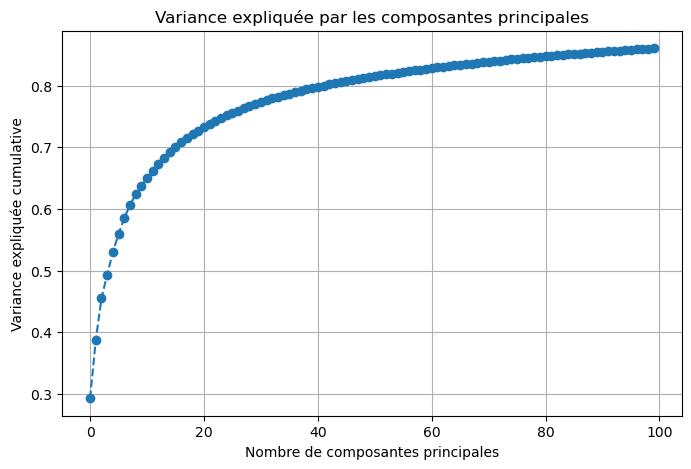

Variance expliquée avec 100 composantes : 0.8607


In [70]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker="o", linestyle="--")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulative")
plt.title("Variance expliquée par les composantes principales")
plt.grid()
plt.show()
print(f"Variance expliquée avec 100 composantes : {cumulative_variance[-1]:.4f}")

### Optimisation du nombre de composantes PCA
- Test de différents nombres de composantes pour maximiser la performance tout en minimisant la complexité.

In [71]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n in [50, 100, 150, 200, 300]:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    knn = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=cv, scoring="accuracy")
    print(f"n_components={n}, Accuracy moyenne : {np.mean(scores):.4f}")

n_components=50, Accuracy moyenne : 0.9480
n_components=100, Accuracy moyenne : 0.9523
n_components=150, Accuracy moyenne : 0.9494
n_components=200, Accuracy moyenne : 0.9461
n_components=300, Accuracy moyenne : 0.9450


**Choix final** : 100 composantes, pour un bon compromis entre variance expliquée et temps de calcul et qui donne même une meilleure accuracy que 150, 200 et 300 composantes.

## 3. **Application de modèles**

### 3.1 **KNN**
- KNN
- Validation croisée
- Tuning des hyperparamètres
- Métriques de performance (accuracy, ROC-AUC, matrice de confusion)
- Comparaison avec train-test split

In [72]:
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train_pca, y_train, cv=cv, scoring="accuracy")
print(f"Accuracy moyenne (KNN, CV) : {np.mean(scores):.4f}")
print(f"Scores de chaque fold : {scores}")

Accuracy moyenne (KNN, CV) : 0.9450
Scores de chaque fold : [0.95019157 0.94534995 0.94822627 0.94055609 0.94055609]


In [ ]:
# Tuning des hyperparamètres
param_grid = {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring="roc_auc")
grid_search.fit(X_train_pca, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur ROC-AUC (CV) :", grid_search.best_score_)

In [ ]:
# Évaluation sur le dataset de validation
knn_best = grid_search.best_estimator_
y_val_pred = knn_best.predict(X_val_pca)
y_val_pred_proba = knn_best.predict_proba(X_val_pca)[:, 1]
print(
    "\nRapport de classification (validation) :\n",
    classification_report(y_val, y_val_pred),
)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)
print(f"ROC-AUC (validation) : {roc_auc_val:.4f}")

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion (KNN, validation)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

In [ ]:
# Courbe ROC
RocCurveDisplay.from_estimator(knn_best, X_val_pca, y_val)
plt.title("Courbe ROC (KNN, validation)")
plt.show()

In [ ]:
### Comparaison avec train-test split
# %%
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=42
)
knn.fit(X_train_split, y_train_split)
val_score = knn.score(X_val_split, y_val_split)
print(f"Accuracy (train-test split) : {val_score:.4f}")

### 4.2 **SVM**
- SVM
- Validation croisée
- Tuning des hyperparamètres
- Métriques de performance (accuracy, ROC-AUC, matrice de confusion)
- Comparaison avec train-test split

Pour la conclusion faire un tableau récapitulatif avec les résultats des différents modèles (KNN, SVM, Random Forest, CNN) et les comparer sur les métriques de performance (accuracy, ROC-AUC, matrice de confusion)
- Visualisation des résultats